# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.766383,True,6.571865
1,1.611373,True,5.208257
2,0.204382,True,5.306437
3,0.167124,True,6.230993
4,1.444499,True,7.289832
...,...,...,...
995,1.008487,True,6.014519
996,-1.625459,False,-0.424256
997,0.537989,True,6.026046
998,0.373068,True,3.962064


<AxesSubplot:xlabel='v0'>

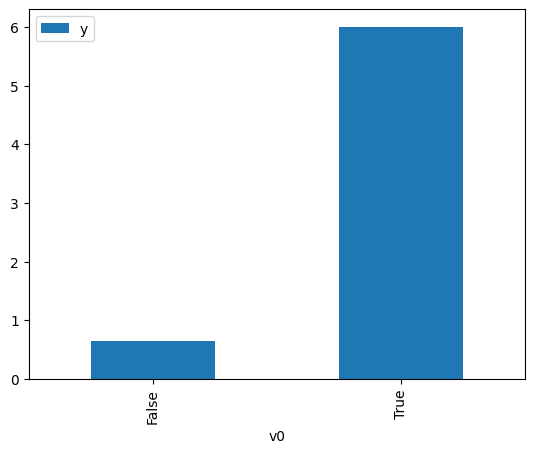

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

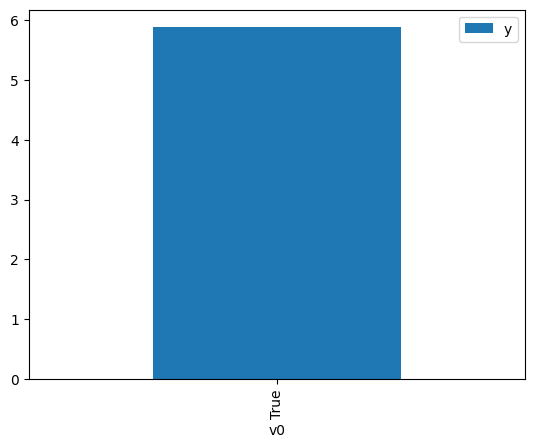

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.500429,False,-0.217267,0.246735,4.052932
1,1.477726,False,2.169214,0.031279,31.970035
2,-0.089597,False,-0.375493,0.570207,1.753749
3,0.373500,False,-1.025621,0.306786,3.259599
4,0.311624,False,3.128146,0.338834,2.951299
...,...,...,...,...,...
995,0.270245,False,-0.802712,0.361146,2.768967
996,1.762040,False,1.843801,0.016190,61.767478
997,0.311624,False,3.128146,0.338834,2.951299
998,-0.122994,False,1.830862,0.589494,1.696371


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.670854,True,5.519186,0.820558,1.218682
1,1.129559,True,5.373370,0.931349,1.073711
2,-0.919950,True,6.180006,0.095242,10.499590
3,0.142944,True,5.300825,0.566749,1.764450
4,2.212337,True,7.707445,0.994373,1.005659
...,...,...,...,...,...
995,1.012502,True,5.388092,0.911339,1.097287
996,1.717759,True,8.097627,0.982050,1.018278
997,0.577517,True,6.167154,0.785643,1.272843
998,1.311013,True,6.522356,0.954252,1.047941


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                          1.487e+04
Date:                Mon, 22 Aug 2022   Prob (F-statistic):                        0.00
Time:                        07:49:00   Log-Likelihood:                         -1396.8
No. Observations:                1000   AIC:                                      2798.
Df Residuals:                     998   BIC:                                      2807.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2346      0.038     32.138      0.000       1.159       1.310
x2             5.0422      0.055     91.020      0.000       4.933       5.151
==============================================================================
Omnibus:                        1.150   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.563   Jarque-Bera (JB):                1.159
Skew:                           0.083   Prob(JB):                        0.560
Kurtosis:                       2.976   Cond. No.                         2.80
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""